In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))

# Purpose
- Purpose of this notebook is to train an CNN model

In [2]:
import warnings
import gc
from IPython.display import display
import joblib

import pandas as pd
import numpy as np
import optuna

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

# Load Data

In [3]:
# load data using joblib
X_train = joblib.load("data/transformed/X_train.pkl")
X_val = joblib.load("data/transformed/X_val.pkl")
X_test = joblib.load("data/transformed/X_test.pkl")

y_train = joblib.load("data/transformed/y_train.pkl")
y_val = joblib.load("data/transformed/y_val.pkl")
y_test = joblib.load("data/transformed/y_test.pkl")

print(f'{X_train.shape=}')
print(f'{y_train.shape=}')
print(f'{X_test.shape=}')
print(f'{y_test.shape=}')

X_train.shape=(31225, 80, 3)
y_train.shape=(31225,)
X_test.shape=(13181, 80, 3)
y_test.shape=(13181,)


# Define model

In [4]:
def cnn_model(**params):

    # define model architecture
    model = Sequential()

    model.add(Conv1D(filters=params['filters'], kernel_size=3, activation='relu', input_shape=(params['timesteps'], params['n_features'])))

    # model.add(Conv1D(filters=params['filters'], kernel_size=3, activation='relu'))

    model.add(Dropout(params["dropout"]))

    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(units=params["units"], activation='relu'))

    model.add(Dense(params['n_classes'], activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['sparse_categorical_accuracy'])
    
    return model

# Hyper-parameter Tuning

In [5]:
def objective(trial: optuna.trial.Trial) -> float:
    '''Takes in hyperparameters as input, and trains a model that computes accuracy on the validation set.'''
    
    clear_session()

    # define hyperparameters
    params = {
        "timesteps": trial.suggest_categorical("timesteps", [X_train.shape[1]]),
        "n_features": trial.suggest_categorical("n_features", [X_train.shape[2]]),
        "n_classes": trial.suggest_categorical("n_classes", [len(np.unique(y_train))]),
        "filters": trial.suggest_categorical("filters", [128, 128*2, 128*3, 128*4, 128*5]),
        "units": trial.suggest_categorical("units", [128, 128*2, 128*3, 128*4, 128*5]),
        "dropout": trial.suggest_uniform("dropout", 0.0, 0.5),
        "batch_size": trial.suggest_categorical("batch_size", [32]),
        "epochs": trial.suggest_categorical("epochs", [100]),
        "patience": trial.suggest_categorical("patience", [10])}
    
    # define early stopping
    early_stop = EarlyStopping(monitor='val_loss',patience=params['patience'])

    model = cnn_model(**params)
        
    # fit model
    model.fit(
        X_train,
        y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        shuffle=False,
        callbacks=[early_stop],
        verbose=False,
    )

    # compute validation error
    score = model.evaluate(X_val, y_val, verbose=0)
    
    return score[1]

In [6]:
warnings.filterwarnings('ignore')

# optuna study
study = optuna.create_study(direction="maximize", study_name="cnn")
study.optimize(objective, n_trials=5)

[I 2023-04-08 10:17:44,516] A new study created in memory with name: cnn
2023-04-08 10:17:44.682990: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



[I 2023-04-08 10:21:37,651] Trial 0 finished with value: 0.7589665651321411 and parameters: {'timesteps': 80, 'n_features': 3, 'n_classes': 6, 'filters': 128, 'units': 256, 'dropout': 0.38778628685796945, 'batch_size': 32, 'epochs': 100, 'patience': 10}. Best is trial 0 with value: 0.7589665651321411.
[I 2023-04-08 10:27:50,136] Trial 1 finished with value: 0.7169199585914612 and parameters: {'timesteps': 80, 'n_features': 3, 'n_classes': 6, 'filters': 128, 'units': 512, 'dropout': 0.22492770442266596, 'batch_size': 32, 'epochs': 100, 'patience': 10}. Best is trial 0 with value: 0.7589665651321411.
[I 2023-04-08 10:41:57,819] Trial 2 finished with value: 0.6818642616271973 and parameters: {'timesteps': 80, 'n_features': 3, 'n_classes': 6, 'filters': 640, 'units': 384, 'dropout': 0.1817924276398199, 'batch_size': 32, 'epochs': 100, 'patience': 10}. Best is trial 0 with value: 0.7589665651321411.
[I 2023-04-08 10:52:39,046] Trial 3 finished with value: 0.7567375898361206 and parameters: 

In [12]:
# # print best parameters
# best_params = study.best_trial.params

In [10]:
# # save best parameters
# joblib.dump(best_params, "models/best_params_cnn.pkl")

['models/best_params_cnn.pkl']

In [5]:
# load best parameters
best_params = joblib.load("models/best_params_cnn.pkl")
for each in best_params:
    print(f'{each} : {best_params[each]}')

timesteps : 80
n_features : 3
n_classes : 6
filters : 128
units : 256
dropout : 0.38778628685796945
batch_size : 32
epochs : 100
patience : 10


# Fit model with best parameters

In [6]:
clear_session()

# define early stopping
early_stop = EarlyStopping(monitor='val_loss',patience=best_params['patience'])

best_model = cnn_model(**best_params)
    
# fit model
best_model.fit(
    X_train,
    y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_data=(X_val, y_val),
    shuffle=False,
    callbacks=[early_stop],
    verbose=False,
)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-10 06:12:43.760579: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 78, 128)           1280      
                                                                 
 dropout (Dropout)           (None, 78, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 39, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4992)              0         
                                                                 
 dense (Dense)               (None, 256)               1278208   
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                        

<Axes: >

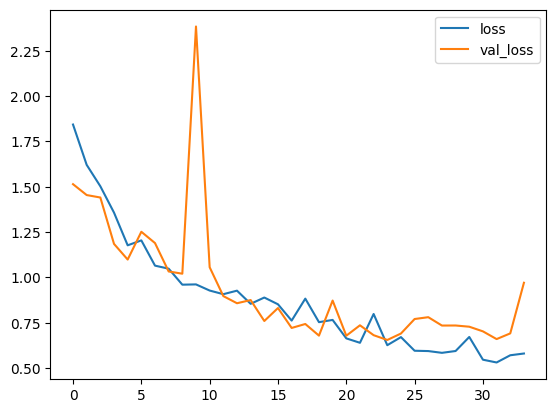

In [8]:
losses = pd.DataFrame(best_model.history.history)
losses[['loss', 'val_loss']].plot()

<Axes: >

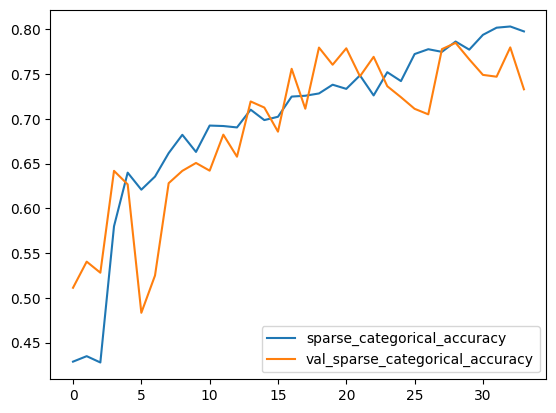

In [9]:
accuracy = pd.DataFrame(best_model.history.history)
accuracy[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [10]:
# Evaluate the model accuracy on the test set.
score = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.057865858078003 / Test accuracy: 0.6776420474052429


# Save Predictions & model

In [11]:
# save the model using joblib
joblib.dump(best_model, "models/model_cnn.pkl")

INFO:tensorflow:Assets written to: ram://e82c607d-f948-4bb3-8073-a6830f65ca09/assets


INFO:tensorflow:Assets written to: ram://e82c607d-f948-4bb3-8073-a6830f65ca09/assets


['models/cnn_model.pkl']

In [12]:
# save predictions
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_pred = pd.DataFrame(y_pred, columns=["predicted_activity"])
y_pred.to_csv("predictions/predictions_cnn.csv", index=False)

412/412 [==============================] - 1s 2ms/step


In [ ]:
# https://link.springer.com/article/10.1007/s11370-021-00358-7 (CNN + LSTM)
# https://ieeexplore.ieee.org/document/7881728 (CNN)
# https://medium.com/@tanmaychauhan111/human-activity-recognition-using-lstm-cnn-8ccb1a42cb81
# user mcnemars test to compare models
# http://alexlenail.me/NN-SVG/LeNet.html (neural network diagram)
# https://www.researchgate.net/figure/The-architecture-of-1D-deep-convolutional-neural-network-for-fold-classification-The_fig1_327213391
# https://www.kaggle.com/code/sylvianclee/human-activity-recognition-cnn-lstm